In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy
import torch.utils.data

# Display Dataset

In [2]:
import sys
sys.path.append('..')

from Datasets.MackeyGlassDataset import MackeyGlassDataset

In [3]:
Mglass1 = MackeyGlassDataset(100, 5, tau=20, seed=0)

Train_test_Split = 0.8
train_size = int(Train_test_Split * len(Mglass1))
test_size = len(Mglass1) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(Mglass1, [train_size, test_size])

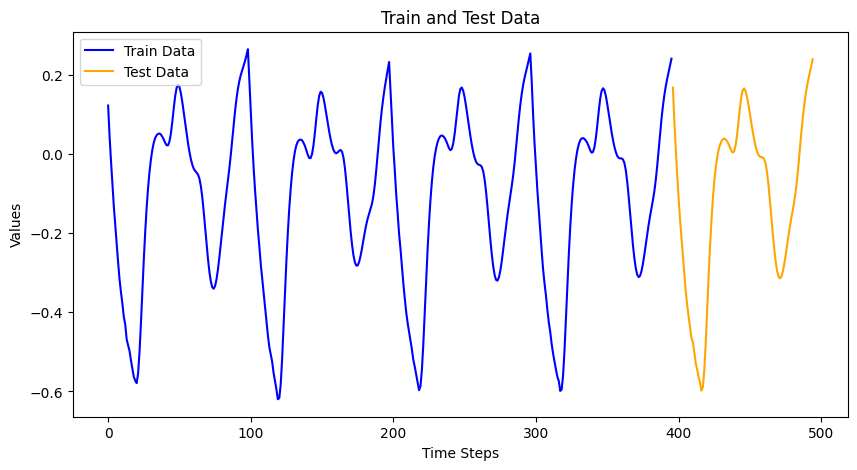

In [4]:
#BUG: This only works for feature size of atleast 2. The dataset will not concatenate otherwise.
# This one is perticularly nasty coz it just won't work even after the check. 
train_data = [data[0].numpy() for data in train_dataset]
test_data = [data[0].numpy() for data in test_dataset]
try: 
    train_data = numpy.concatenate(train_data, axis=0)
    test_data = numpy.concatenate(test_data, axis=0)
except: 
    pass

# Append train and test data into one array
combined_data = np.concatenate((train_data, test_data), axis=0)
#BUG! the data is loosing it's sequentiality.
# Plot the combined data with different colors representing train and test data
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_data)), train_data, label='Train Data', color='blue')
plt.plot(range(len(train_data), len(combined_data)), test_data, label='Test Data', color='orange')
plt.legend()
plt.title('Train and Test Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

# ESN Performance

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU is available')
else:
    device = torch.device('cpu')
    print('GPU not available')

train_loader = DataLoader(train_data, batch_size=1, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

train_ = np.array([])
for data in train_loader:
    temp = data[0].numpy()
    train_ = np.append(train_, temp)

GPU not available


In [6]:
from Models.Echostate import ESN

esn = ESN(input_dim = 1, reservoir_dim = 200, output_dim = 1)
esn.to(device)
esn.freeze_reservoir()  # Freeze reservoir weights

# Define optimizer and criterion for the readout layer
optimizer = torch.optim.Adam(esn.readout.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [7]:
inputs = torch.tensor(train_data).to(device)
targets = torch.tensor(train_data).to(device)

for name, param in esn.named_parameters():
    print(f"{name} is on {param.device}")

print(inputs.device, targets.device)


readout.weight is on cpu
readout.bias is on cpu
cpu cpu


In [8]:
epochs = 50
outputs = torch.rand(len(inputs), 1).to(device)  # Initialize outputs tensor
outputs.device
outputs = outputs.to(device)  # Ensure inputs are on the same device as the model
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = esn(inputs)  # Forward pass
    loss = criterion(outputs, inputs)  # Compute loss
    loss.backward()  # Backpropagate
    optimizer.step()  # Update only the readout layer
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    if epoch == epochs - 1:
        print(f"Final loss: {loss.item()}")

Epoch 1, Loss: 0.057735852897167206
Epoch 11, Loss: 0.0032823870424181223
Epoch 21, Loss: 0.0020754868164658546
Epoch 31, Loss: 0.0017209581565111876
Epoch 41, Loss: 0.0004009829426649958
Final loss: 0.00022947325487621129


In [9]:
esn.eval()
#esn.Reservoir()
#esn.Params()

ESN(
  (readout): Linear(in_features=200, out_features=1, bias=True)
)

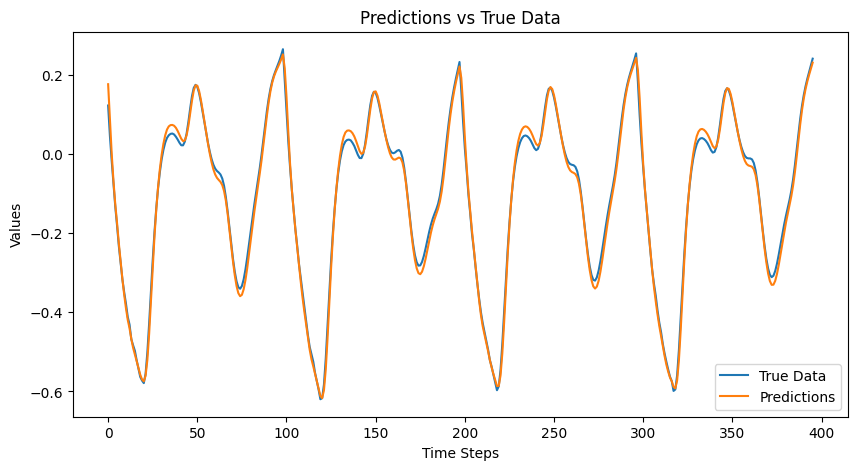

In [10]:
plt.figure(figsize=(10, 5))
targets = targets.cpu()
outputs = outputs.cpu()
plt.plot(targets.numpy(), label='True Data')
plt.plot(outputs.detach().numpy(), label='Predictions')
plt.legend()
plt.title('Predictions vs True Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.show()

In [11]:
Reservoir_states = esn.__get_reservoir_states__()
Readout = esn.__get_readout__()
Reservoir_state = esn.__get_reservoir_state__()

Reservoir_states.size(), Reservoir_state.size(), Readout

(torch.Size([396, 200]),
 torch.Size([200]),
 Linear(in_features=200, out_features=1, bias=True))

In [12]:
%%script false --no-raise-error

test_data = torch.tensor(test_data).to(device)
test_output = []  # To store all predictions

# First prediction (using initial test data)
current_input = test_data[0].unsqueeze(0)  # The first data point as input to the ESN
test_output.append(esn(current_input))  # Get the first prediction

# Now use the last prediction to get the next one
for i in range(1, 30):
    # Get the last output, remove any extra dimensions, and reshape it if necessary
    current_input = test_output[i-1].unsqueeze(0)  # Get the last prediction as input for the next step
    #current_input = current_input.view(1, -1)  # Flatten it if necessary (if the ESN needs a 1D vector)
    next_output = esn(current_input)  # Generate the next prediction
    test_output.append(next_output)  # Append it to the output list

# Convert test_output back to a tensor if necessary
#test_output = torch.cat(test_output, dim=0)

In [13]:
test_data = torch.tensor(test_data).to(device)
test_output = []  # To store all predictions

# First prediction (using initial test data)
current_input = test_data[0].unsqueeze(0)  # The first data point as input to the ESN
test_output.append(esn(current_input))  # Get the first prediction

current_input, test_output

(tensor([[0.1672]]), [tensor([[0.1964]], grad_fn=<StackBackward0>)])

In [14]:
%%script false --no-raise-error

test_data = torch.tensor(test_data).to(device)
test_output = outputs[-1:].to(device)

for i in range(len(test_data)):
    if i == 0:
        test_output = esn(temp[i].unsqueeze(0))
    else:
        test_output = torch.cat((test_output, esn(test_output[i-1].unsqueeze(0))), dim=0)

test_output

In [15]:
test_data = test_data.cpu()
test_output = test_output.cpu()

plt.figure(figsize=(10, 5))
plt.plot(test_data.numpy(), label='True Data')
plt.plot(test_output.detach().numpy(), label='Predictions')
plt.legend()
plt.title('Predictions vs True Data')
plt.xlabel('Time Steps')
plt.ylabel('Values')

AttributeError: 'list' object has no attribute 'cpu'